Cleaned data loaded successfully.
Scikit-Learn Multi-Variate Bernoulli Naive Bayes - Accuracy: 0.9394
Scikit-Learn Multi-Variate Bernoulli Naive Bayes - Confusion Matrix:
[[3647  471]
 [  40 4271]]
Scikit-Learn Multi-Variate Bernoulli Naive Bayes - Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.89      0.93      4118
        Spam       0.90      0.99      0.94      4311

    accuracy                           0.94      8429
   macro avg       0.94      0.94      0.94      8429
weighted avg       0.94      0.94      0.94      8429


Scikit-Learn Multinomial Boolean Naive Bayes - Accuracy: 0.9745
Scikit-Learn Multinomial Boolean Naive Bayes - Confusion Matrix:
[[4010  108]
 [ 107 4204]]
Scikit-Learn Multinomial Boolean Naive Bayes - Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      0.97      0.97      4118
        Spam       0.97      0.98      0.98      4311

    accura

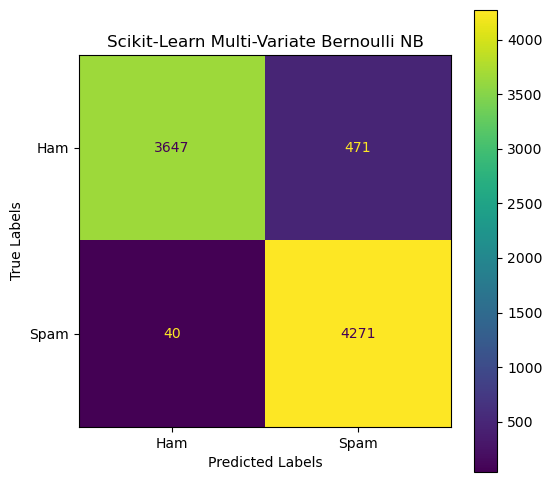

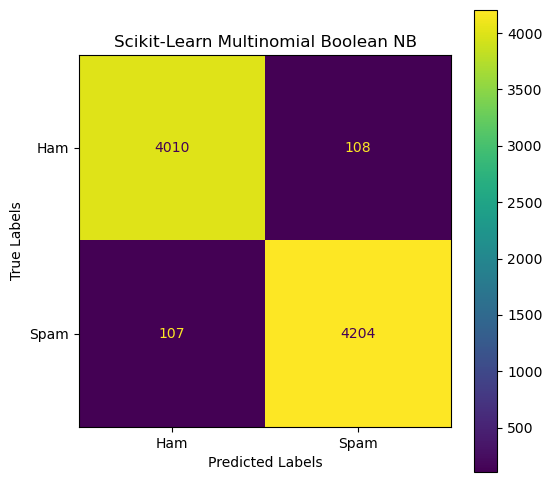

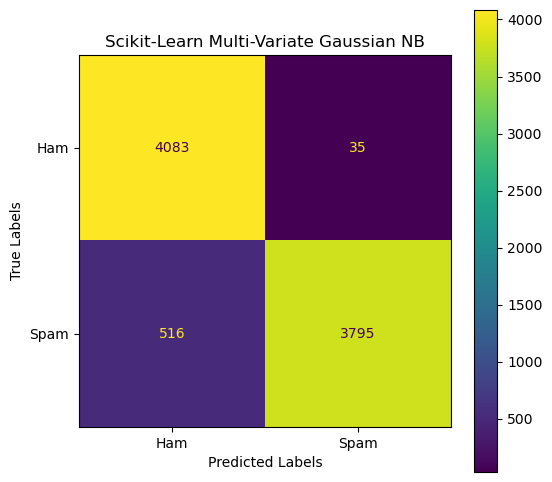

In [11]:
import numpy as np
import pandas as pd
import re
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix, ConfusionMatrixDisplay


# Load and clean data
cleaned_data_path = 'cleaned_enron_spam_data.csv'
if not os.path.exists(cleaned_data_path):
    data = pd.read_csv('enron_spam_data.csv')
    data['Message'] = data['Message'].apply(lambda text: re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9]', ' ', text).lower()) if pd.notna(text) else '')
    data.to_csv(cleaned_data_path, index=False)
else:
    data = pd.read_csv(cleaned_data_path)
    print("Cleaned data loaded successfully.")

# Properly handling NaNs by converting them to an empty string before joining
data['Message_str'] = data['Message'].apply(lambda x: ' '.join(str(x).split()))

# Load the vocabulary
top_vocab = np.load('top_vocab.npy', allow_pickle=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Message_str'], data['Spam/Ham'], test_size=0.25, random_state=42)

# Vectorization of text data
vectorizer = CountVectorizer(binary=True, min_df=5, vocabulary=top_vocab)  # For Bernoulli NB
X_train_bern = vectorizer.fit_transform(X_train)
X_test_bern = vectorizer.transform(X_test)

vectorizer = CountVectorizer(min_df=5, vocabulary=top_vocab)  # For Multinomial NB
X_train_multi = vectorizer.fit_transform(X_train)
X_test_multi = vectorizer.transform(X_test)

# Using Gaussian NB requires features with a normal distribution, hence TF-IDF can be an alternative
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=top_vocab)
X_train_gauss = tfidf_vectorizer.fit_transform(X_train)
X_test_gauss = tfidf_vectorizer.transform(X_test)

# Initialize Naive Bayes classifiers
bern_nb = BernoulliNB()
multi_nb = MultinomialNB()
gauss_nb = GaussianNB()

# Training Bernoulli NB
bern_nb.fit(X_train_bern, y_train)
# Training Multinomial NB
multi_nb.fit(X_train_multi, y_train)
# # Training Gaussian NB
gauss_nb.fit(X_train_gauss.toarray(), y_train)  # GaussianNB expects dense input

# Prediction and Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test.toarray() if model_name == 'Scikit-Learn Multi-Variate Gaussian' else X_test)
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    # Display the confusion matrix with sklearn's ConfusionMatrixDisplay
    classes = ['Ham', 'Spam']
    sklearn_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    fig, ax = plt.subplots(figsize=(6, 6))
    sklearn_disp.plot(ax=ax, cmap='viridis', values_format='g')  # 'g' for generic number format
    ax.set_title(f'{model_name} NB')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    
    # Setting the tick marks with class names for clarity
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    class_report = classification_report(y_test, predictions, target_names=['Ham', 'Spam'])

    print(f"{model_name} Naive Bayes - Accuracy: {accuracy:.4f}")
    print(f"{model_name} Naive Bayes - Confusion Matrix:\n{conf_matrix}")
    print(f"{model_name} Naive Bayes - Classification Report:\n{class_report}\n")
    return accuracy, conf_matrix, class_report 

# Evaluate all models
#evaluate_model(bern_nb, X_train_bern, y_train, 'Bernoulli')
B_accuracy, B_conf_matrix, B_class_report= evaluate_model(bern_nb, X_test_bern, y_test, 'Scikit-Learn Multi-Variate Bernoulli')
M_accuracy, M_conf_matrix, M_class_report= evaluate_model(multi_nb, X_test_multi, y_test, 'Scikit-Learn Multinomial Boolean')
G_accuracy, G_conf_matrix, G_class_report= evaluate_model(gauss_nb, X_test_gauss, y_test, 'Scikit-Learn Multi-Variate Gaussian')


## Top Method words = .9394 Test Bernoulli